In [1]:
import time
start = time.time()
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKerasTF
import funzioni as fz
import importlib
from collections import Counter
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
import pickle
from tensorflow.keras.layers import Dense, Input, Conv1D, Dropout, MaxPooling1D, Flatten, concatenate, AveragePooling1D
from tensorflow.keras.models import Model
gpus = tf.config.experimental.list_physical_devices('GPU')
from tensorflow.keras.utils import plot_model
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier


print(gpus)
if gpus:
  # Restrict TensorFlow to only use the second GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)


from tensorflow.keras.layers import Conv1D, Activation, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def print_count(labels):
    c=Counter(labels)
    print(sorted(c.items()))
    tot=sum(c.values())
    for item in c.items():
        print(item[0], round(item[1]/tot*100, 2), '%')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#data loading
data1=pd.read_pickle('./data/alldatatype.ino.pkl')
data2=pd.read_pickle('./data/alldatatype.notino.pkl')
data = pd.DataFrame(np.concatenate([data1, data2]), columns=data1.columns)

cut=2250 #50 gradi
X=data.iloc[:,0:cut]
y=data.iloc[:,3251:]
y['class']=y.apply(np.argmax, axis=1)
print_count(y['class'])
y=y['class']

[(0, 66643), (1, 15999), (2, 184929), (3, 12803), (4, 8146), (5, 92261), (6, 16554)]
0 16.77 %
3 3.22 %
1 4.03 %
2 46.54 %
5 23.22 %
4 2.05 %
6 4.17 %


/lustrehome/diacono/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [4]:
#peaks dataframe (all peaks position)
peaks=X.apply(find_peaks, axis=1).apply(lambda x:pd.Series(x))
peaks=peaks.drop(1, axis=1)
peaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397335 entries, 0 to 397334
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       397335 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [5]:
peaks

,0
0,"[798, 994, 1102, 1387, 1784, 1883, 1940, 2007,..."
1,"[132, 223, 323, 469, 478, 515, 535, 595, 631, ..."
2,"[101, 247, 453, 537, 609, 645, 712, 747, 808, ..."
3,"[131, 385, 491, 514, 589, 654, 745, 805, 888, ..."
4,"[534, 1106, 1138, 1333, 1343, 1534, 1694, 1717..."
...,...
397330,"[27, 146, 304, 317, 372, 381, 448, 481, 519, 5..."
397331,"[15, 281, 340, 363, 393, 411, 428, 497, 539, 5..."
397332,"[22, 129, 140, 184, 193, 232, 252, 287, 294, 3..."
397333,"[73, 105, 235, 298, 319, 334, 348, 382, 391, 4..."


In [6]:
#transform into series
peaks_series = peaks.squeeze()

In [7]:
#flag the rows that don't have enough peaks
cut=10

def truncate(x):
    if len(x)>cut+1:
        return x[0:cut], int(len(x))
    else:
        return 'toberemoved'

peaks_series_trunc=peaks_series.apply(truncate)

In [8]:
#Get the indexes of flagged rows
drop_indexes=peaks_series_trunc[peaks_series_trunc == 'toberemoved'].index
#print(drop_indexes)
#drop the rows and the corresponding labels
peaks_series_trunc=peaks_series_trunc.drop(drop_indexes)
print(len(drop_indexes))
y_trunc=y.drop(drop_indexes)

18234


In [9]:
X_peaks=pd.DataFrame.from_dict(dict(zip(peaks_series_trunc.index, peaks_series_trunc.values))).T
X_peaks.columns=['peaks','len']

In [10]:
X_cut = pd.concat([X_peaks.peaks.apply(pd.Series), X_peaks.len], axis=1)

In [11]:
X_cut.len=X_cut.len.astype('int64')

In [12]:
X_cut

,0,1,2,3,4,5,6,7,8,9,len
1,132,223,323,469,478,515,535,595,631,708,50
2,101,247,453,537,609,645,712,747,808,835,62
3,131,385,491,514,589,654,745,805,888,900,55
4,534,1106,1138,1333,1343,1534,1694,1717,1992,2026,14
5,501,528,555,615,697,777,797,864,880,926,64
...,...,...,...,...,...,...,...,...,...,...,...
397330,27,146,304,317,372,381,448,481,519,547,117
397331,15,281,340,363,393,411,428,497,539,549,119
397332,22,129,140,184,193,232,252,287,294,310,163
397333,73,105,235,298,319,334,348,382,391,445,145


<AxesSubplot:>

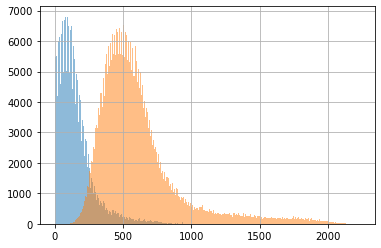

In [13]:
X_cut[0].hist(bins='auto',alpha=0.5)
X_cut[9].hist(bins='auto',alpha=0.5)

<AxesSubplot:>

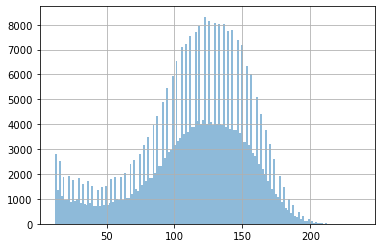

In [14]:
X_cut['len'].hist(bins='auto',alpha=0.5)

---

### Test between XGBoost and RF (first 10 peaks)

In [130]:
#with the peak series lenght, not scaled
from xgboost import XGBClassifier
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.68587, std (0.005) 


In [132]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.76829, (std 0.005) 


In [133]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_cut)
X_cut=scaler.transform(X_cut)

In [134]:
#with the peak series lenght, scaled
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.68587, (std 0.005) 


In [135]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.76786, (std 0.006) 


In [136]:
X_cut_nolen=X_cut.drop(['len'], axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [106]:
#without the peak series lenght
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut_nolen, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.65399


In [107]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut_nolen, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.75194


<AxesSubplot:>

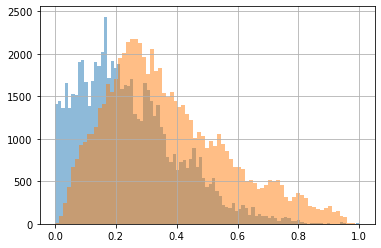

In [116]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_cut_nolen)
scaled=pd.DataFrame(scaler.transform(X_cut_nolen), columns=X_cut_nolen.columns)
scaled[0].hist(bins='auto',alpha=0.5)
scaled[9].hist(bins='auto',alpha=0.5)

In [117]:
#scaled, without len
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, scaled, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f' % np.mean(scores))

Mean F1: 0.65404


In [118]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut_nolen, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, std (%.3f) ' % np.mean(scores))

Mean F1: 0.75200


---

### Random Forest Test

In [15]:
print(len(X_cut))
print(len(y_trunc))

379101
379101


In [16]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

Mean F1: 0.60620, (std 0.003) 


In [17]:
model = RandomForestClassifier(n_estimators=500)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_cut, y_trunc, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1: %.5f, (std %.3f) ' % ( np.mean(scores), np.std(scores)))

/lustrehome/diacono/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

---

### Deep learning test

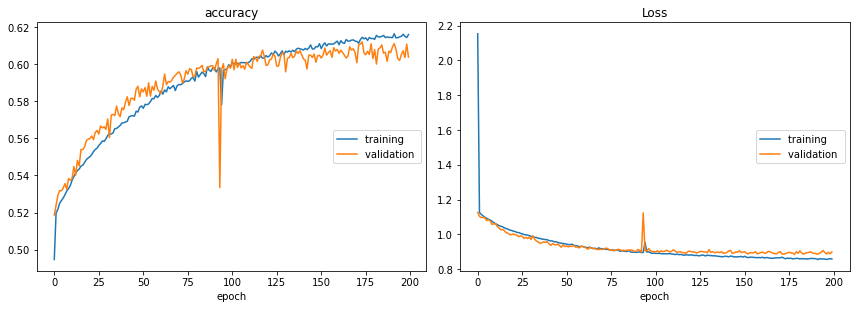

accuracy
	training         	 (min:    0.495, max:    0.616, cur:    0.616)
	validation       	 (min:    0.519, max:    0.612, cur:    0.604)
Loss
	training         	 (min:    0.855, max:    2.154, cur:    0.858)
	validation       	 (min:    0.885, max:    1.126, cur:    0.899)
f1 train: 0.629850009360438
f1 test: 0.5760426468005332


In [18]:
drop=0.1
reg=0.01

def create_model(X):
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(X.shape[1],), activation=tf.nn.swish),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(512, activation=tf.nn.swish),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(512, activation=tf.nn.swish),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(512, activation=tf.nn.swish),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(512, activation=tf.nn.swish),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(7, activation=tf.nn.softmax),
    ])
    optimizer = keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

plotlosses = PlotLossesKerasTF()

train_set, test_set, train_labels, test_labels = train_test_split(X_cut, y_trunc, test_size = 0.10, random_state = 42, shuffle=True,stratify=y_trunc)
model = create_model(train_set)
model.fit(train_set, train_labels, batch_size = 800, verbose = 0, epochs=200, validation_split=0.20, shuffle=True, callbacks=[plotlosses])

y_pred_train = model.predict(train_set)
y_pred_test = model.predict(test_set)
f1_train_par=f1_score(train_labels,np.argmax(y_pred_train, axis=1), average='weighted')
f1_test_par=f1_score(test_labels, np.argmax(y_pred_test, axis=1), average='weighted')
print('f1 train:', f1_train_par)
print('f1 test:', f1_test_par)
#scores=model.evaluate(X_test_pca, y_test, verbose=0)
#print(model.metrics_names)
#print(scores)